# Cassini 1 (MGA transfer) optimization with PyGMO

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Objectives 

This example illustrates the usage of PyGMO to optimize an interplanetary transfer trajectory simulated using the multiple gravity assist (MGA) module of Tudat. The trajectory optimization of the Cassini 1 problem, which corresponds to a simplified version of the real Cassini mission, is here solved. The Cassini 1 problem departs from the edge of Earth's SOI, executes gravity assists at Venus, Venus, Earth, and Jupiter, and finally is inserted into an orbit around Saturn with eccentricity $e = 0.98$ and semi-major axis $a = 1.0895e8 / 0.02$ km. Each transfer leg (i.e. between each two planets) is considered to be unpowered, with $\Delta V$ s applied only during the gravity assists. Hence, the transfer is modeled as an [MGA with unpowered unperturbed legs](https://py.api.tudat.space/en/latest/transfer_trajectory.html#tudatpy.trajectory_design.transfer_trajectory.mga_settings_unpowered_unperturbed_legs).

The 6 design variables are:

* Departure time
* Time of flight between consecutive planets (5 variables)

The only objective function is the $\Delta V$, which is minimized.

The Cassini 1 problem (among others) has been proposed and solved by ESA Advanced Concepts Team [(Vinkó et al, 2007)](https://www.esa.int/gsp/ACT/doc/MAD/pub/ACT-RPR-MAD-2007-BenchmarkingDifferentGlobalOptimisationTechniques.pdf). In this and other papers, various global optimisation problems related to spacecraft trajectory design are described and solved.

PyGMO is used in this example. It is assumed that the reader of this tutorial is already familiar with the content of [this basic PyGMO tutorial](https://docs.tudat.space/en/latest/_src_advanced_topics/optimization_pygmo.html#about-pygmo).

## Import statements

The required import statements are made here, at the very beginning. Some standard modules are first loaded (numpy, matplotlib and typing). Then, the different modules of tudatpy that will be used are imported. Finally, in this example, we also need to import the pygmo library.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Tudat imports
import tudatpy
from tudatpy.trajectory_design import transfer_trajectory
from tudatpy import constants
from tudatpy.dynamics import environment_setup
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime

# Pygmo imports
import pygmo as pg

## Helpers

First of all, let us define a helper function which is used throughout this example.

The design variables in the current optimization problem are the departure time and the time of flight between transfer nodes. However, to evaluate an MGA trajectory in Tudat it is necessary to specify a different set of parameters: node times, node free parameters, leg free parameters. This function converts a vector of design variables to the parameters which are used as input to the MGA trajectory object.

The node times are easily computed based on the departure time and the time of flight between nodes. Since an MGA transfer with unpowered legs is used, no node and leg free parameters are required; thus, these are defined as empty lists.

In [2]:
def convert_trajectory_parameters(
    transfer_trajectory_object: tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory,
    trajectory_parameters: List[float],
) -> Tuple[List[float], List[List[float]], List[List[float]]]:

    # Declare lists of transfer parameters
    node_times = list()
    leg_free_parameters = list()
    node_free_parameters = list()

    # Extract from trajectory parameters the lists with each type of parameters
    departure_time = trajectory_parameters[0]
    times_of_flight_per_leg = trajectory_parameters[1:]

    # Get node times
    # Node time for the initial node: departure time
    node_times.append(departure_time)
    # None times for other nodes: node time of the previous node plus time of flight
    accumulated_time = departure_time
    for i in range(0, transfer_trajectory_object.number_of_nodes - 1):
        accumulated_time += times_of_flight_per_leg[i]
        node_times.append(accumulated_time)

    # Get leg free parameters and node free parameters: one empty list per leg
    for i in range(transfer_trajectory_object.number_of_legs):
        leg_free_parameters.append([])
    # One empty array for each node
    for i in range(transfer_trajectory_object.number_of_nodes):
        node_free_parameters.append([])

    return node_times, leg_free_parameters, node_free_parameters

## Optimisation problem

The core of the optimization process is realized by PyGMO, which requires the definition of a problem class.
This definition has to be done in a class that is compatible with what the PyGMO library expects from a User Defined Problem (UDP). See [this page](https://esa.github.io/pygmo2/tutorials/coding_udp_simple.html) from the PyGMO's documentation as a reference. In this example, this class is called `TransferTrajectoryProblem`.

There are four mandatory methods that must be implemented in the class:

* `__init__()`: This is the constructor for the PyGMO problem class. It is used to save all the variables required to setup the evaluation of the transfer trajectory.
* `get_number_of_parameters(self)`: Returns the number of optimized parameters. In this case, that is the same as the number of flyby bodies (i.e. 6).
* `get_bounds(self)`: Returns the bounds for each optimized parameter. These are provided as an input to `__init__()`. Their values are defined later in this example.
* `fitness(self, x)`: Returns the cost associated with a vector of design parameters. Here, the fitness is the $\Delta V$ required to execute the transfer.

In [3]:
###########################################################################
# CREATE PROBLEM CLASS ####################################################
###########################################################################


class TransferTrajectoryProblem:

    def __init__(
        self,
        transfer_trajectory_object: tudatpy.trajectory_design.transfer_trajectory.TransferTrajectory,
        departure_date_lb: float,  # Lower bound on departure date
        departure_date_ub: float,  # Upper bound on departure date
        legs_tof_lb: np.ndarray,  # Lower bounds of each leg's time of flight
        legs_tof_ub: np.ndarray,
    ):  # Upper bounds of each leg's time of flight
        """
        Class constructor.
        """

        self.departure_date_lb = departure_date_lb
        self.departure_date_ub = departure_date_ub
        self.legs_tof_lb = legs_tof_lb
        self.legs_tof_ub = legs_tof_ub

        # Save the transfer trajectory object as a lambda function
        # PyGMO internally pickles its user defined objects and some objects cannot be pickled properly without using lambda functions.
        self.transfer_trajectory_function = lambda: transfer_trajectory_object

    def get_bounds(self) -> tuple:
        """
        Returns the boundaries of the decision variables.
        """

        # Retrieve transfer trajectory object
        transfer_trajectory_obj = self.transfer_trajectory_function()

        number_of_parameters = self.get_number_of_parameters()

        # Define lists to save lower and upper bounds of design parameters
        lower_bound = list(np.empty(number_of_parameters))
        upper_bound = list(np.empty(number_of_parameters))

        # Define boundaries on departure date
        lower_bound[0] = self.departure_date_lb
        upper_bound[0] = self.departure_date_ub

        # Define boundaries on time of flight between bodies ['Earth', 'Venus', 'Venus', 'Earth', 'Jupiter', 'Saturn']
        for i in range(0, transfer_trajectory_obj.number_of_legs):
            lower_bound[i + 1] = self.legs_tof_lb[i]
            upper_bound[i + 1] = self.legs_tof_ub[i]

        bounds = (lower_bound, upper_bound)
        return bounds

    def get_number_of_parameters(self):
        """
        Returns number of parameters that will be optimized
        """

        # Retrieve transfer trajectory object
        transfer_trajectory_obj = self.transfer_trajectory_function()

        # Get number of parameters: it's the number of nodes (time at the first node, and time of flight to reach each subsequent node)
        number_of_parameters = transfer_trajectory_obj.number_of_nodes

        return number_of_parameters

    def fitness(self, trajectory_parameters: List[float]) -> list:
        """
        Returns delta V of the transfer trajectory object with the given set of trajectory parameters
        """

        # Retrieve transfer trajectory object
        transfer_trajectory = self.transfer_trajectory_function()

        # Convert list of trajectory parameters to appropriate format
        node_times, leg_free_parameters, node_free_parameters = (
            convert_trajectory_parameters(transfer_trajectory, trajectory_parameters)
        )

        # Evaluate trajectory
        try:
            transfer_trajectory.evaluate(
                node_times, leg_free_parameters, node_free_parameters
            )
            delta_v = transfer_trajectory.delta_v

        # If there was some error in the evaluation of the trajectory, use a very large deltaV as penalty
        except:
            delta_v = 1e10

        return [delta_v]

## Simulation Setup 

Before running the optimisation, it is first necessary to setup the simulation. In this case, this consists of creating an MGA object. This object is created according to the procedure described in the [MGA trajectory example](mga_trajectories.ipynb). The object is created using the central body, transfer bodies order, departure orbit, and arrival orbit specified in the Cassini 1 problem statement (presented above).

In [4]:
###########################################################################
# Define transfer trajectory properties
###########################################################################

# Define the central body
central_body = "Sun"

# Define order of bodies (nodes)
transfer_body_order = ["Earth", "Venus", "Venus", "Earth", "Jupiter", "Saturn"]

# Define departure orbit
departure_semi_major_axis = np.inf
departure_eccentricity = 0

# Define insertion orbit
arrival_semi_major_axis = 1.0895e8 / 0.02
arrival_eccentricity = 0.98

# Create simplified system of bodies
bodies = environment_setup.create_simplified_system_of_bodies()

# Define the trajectory settings for both the legs and at the nodes
transfer_leg_settings, transfer_node_settings = (
    transfer_trajectory.mga_settings_unpowered_unperturbed_legs(
        transfer_body_order,
        departure_orbit=(departure_semi_major_axis, departure_eccentricity),
        arrival_orbit=(arrival_semi_major_axis, arrival_eccentricity),
    )
)

# Create the transfer calculation object
transfer_trajectory_object = transfer_trajectory.create_transfer_trajectory(
    bodies,
    transfer_leg_settings,
    transfer_node_settings,
    transfer_body_order,
    central_body,
)

## Optimization

### Optimization Setup 

Before executing the optimization, it is necessary to select the bounds for the optimized parameters (departure date and time of flight per transfer leg). These are selected according to the values in the Cassini 1 problem statement [(Vinkó et al, 2007)](https://www.esa.int/gsp/ACT/doc/MAD/pub/ACT-RPR-MAD-2007-BenchmarkingDifferentGlobalOptimisationTechniques.pdf).

In [ ]:
# Lower and upper bound on departure date
departure_date_lb = DateTime(1997, 4, 6).to_epoch()
departure_date_ub = DateTime(1999, 12, 31).to_epoch()

# List of lower and upper on time of flight for each leg
legs_tof_lb = np.zeros(5)
legs_tof_ub = np.zeros(5)
# Venus first fly-by
legs_tof_lb[0] = 30 * constants.JULIAN_DAY
legs_tof_ub[0] = 400 * constants.JULIAN_DAY
# Venus second fly-by
legs_tof_lb[1] = 100 * constants.JULIAN_DAY
legs_tof_ub[1] = 470 * constants.JULIAN_DAY
# Earth fly-by
legs_tof_lb[2] = 30 * constants.JULIAN_DAY
legs_tof_ub[2] = 400 * constants.JULIAN_DAY
# Jupiter fly-by
legs_tof_lb[3] = 400 * constants.JULIAN_DAY
legs_tof_ub[3] = 2000 * constants.JULIAN_DAY
# Saturn fly-by
legs_tof_lb[4] = 1000 * constants.JULIAN_DAY
legs_tof_ub[4] = 6000 * constants.JULIAN_DAY

To setup the optimization, it is first necessary to initialize the optimization problem. This problem, defined through the class `TransferTrajectoryProblem`, is given to PyGMO trough the `pg.problem()` method.

The optimiser is selected to be the Differential Evolution (DE) algorithm (its documentation can be found [here](https://esa.github.io/pygmo2/algorithms.html#pygmo.de)). When selecting the algorithm, here the coefficient F is selected to have the value 0.5, instead of the default 0.8. Additionally, a fixed seed is selected; since PyGMO uses a random number generator, this ensures that PyGMO's results are reproducible.

Finally, the initial population is created, with a size of 20 individuals.

In [6]:
###########################################################################
# Setup optimization
###########################################################################
# Initialize optimization class
optimizer = TransferTrajectoryProblem(
    transfer_trajectory_object,
    departure_date_lb,
    departure_date_ub,
    legs_tof_lb,
    legs_tof_ub,
)

# Creation of the pygmo problem object
prob = pg.problem(optimizer)

# To print the problem's information: uncomment the next line
# print(prob)

# Define number of generations per evolution
number_of_generations = 1

# Fix seed
optimization_seed = 4444

# Create pygmo algorithm object
algo = pg.algorithm(pg.de(gen=number_of_generations, seed=optimization_seed, F=0.5))

# To print the algorithm's information: uncomment the next line
# print(algo)

# Set population size
population_size = 20

# Create population
pop = pg.population(prob, size=population_size, seed=optimization_seed)

### Run Optimization 

Finally, the optimization can be executed by successively evolving the defined population.

A total number of evolutions of 800 is selected. Thus, the method `algo.evolve()` is called 800 times inside a loop. After each evolution, the best fitness and the list with the best design variables are saved.

In [7]:
###########################################################################
# Run optimization
###########################################################################

# Set number of evolutions
number_of_evolutions = 800

# Initialize empty containers
individuals_list = []
fitness_list = []

for i in range(number_of_evolutions):

    pop = algo.evolve(pop)

    # individuals save
    individuals_list.append(pop.champion_x)
    fitness_list.append(pop.champion_f)

print("The optimization has finished")

The optimization has finished


## Results Analysis

Having finished the optimisation, it is now possible to analyse the results.

According to [Vinkó et al (2007)](https://www.esa.int/gsp/ACT/doc/MAD/pub/ACT-RPR-MAD-2007-BenchmarkingDifferentGlobalOptimisationTechniques.pdf), the best known solution for the Cassini 1 problem has a final objective function value of 4.93 km/s.

The executed optimization process results in a final objective function value of 4933.17 m/s, with a slightly different decision vector from the one presented by Vinkó et al. (2017). This marginal difference can be explained by an inperfect convergence of the used optimizer, which is expected, considering that DE is a global optimizer. 

The evolution of the minimum $\Delta V$ throughout the optimization process can be plotted.


########### CHAMPION INDIVIDUAL ###########

Total Delta V [m/s]:  5689.227740982542
Departure time w.r.t J2000 [days]:  -784.5080976760612
Earth-Venus time of flight [days]:  176.01728454864363
Venus-Venus time of flight [days]:  416.8502293466768
Venus-Earth time of flight [days]:  60.51040922500553
Earth-Jupiter time of flight [days]:  951.8527234337222
Jupiter-Saturn time of flight [days]:  4418.416971184073


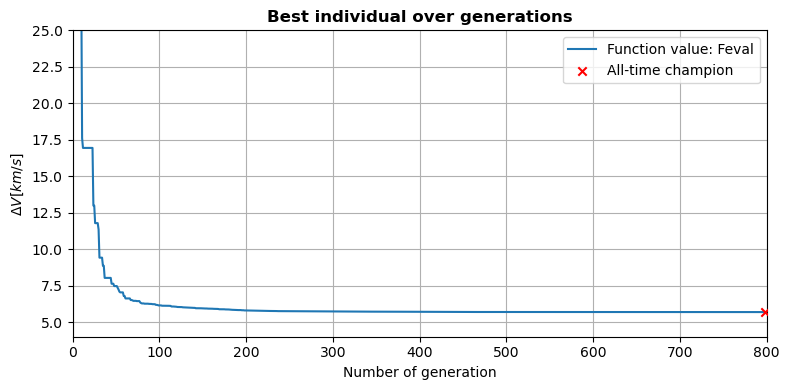

In [8]:
###########################################################################
# Results post-processing
###########################################################################

# Extract the best individual
print("\n########### CHAMPION INDIVIDUAL ###########\n")
print("Total Delta V [m/s]: ", pop.champion_f[0])
best_decision_variables = pop.champion_x / constants.JULIAN_DAY
print("Departure time w.r.t J2000 [days]: ", best_decision_variables[0])
print("Earth-Venus time of flight [days]: ", best_decision_variables[1])
print("Venus-Venus time of flight [days]: ", best_decision_variables[2])
print("Venus-Earth time of flight [days]: ", best_decision_variables[3])
print("Earth-Jupiter time of flight [days]: ", best_decision_variables[4])
print("Jupiter-Saturn time of flight [days]: ", best_decision_variables[5])

# Plot fitness over generations
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    np.arange(0, number_of_evolutions),
    np.float_(fitness_list) / 1000,
    label="Function value: Feval",
)
# Plot champion
champion_n = np.argmin(np.array(fitness_list))
ax.scatter(
    champion_n,
    np.min(fitness_list) / 1000,
    marker="x",
    color="r",
    label="All-time champion",
    zorder=10,
)

# Prettify
ax.set_xlim((0, number_of_evolutions))
ax.set_ylim([4, 25])
ax.grid("major")
ax.set_title("Best individual over generations", fontweight="bold")
ax.set_xlabel("Number of generation")
ax.set_ylabel(r"$\Delta V [km/s]$")
ax.legend(loc="upper right")
plt.tight_layout()
plt.legend()

### Plot the transfer
Finally, the position history throughout the transfer can be retrieved from the transfer trajectory object and plotted.

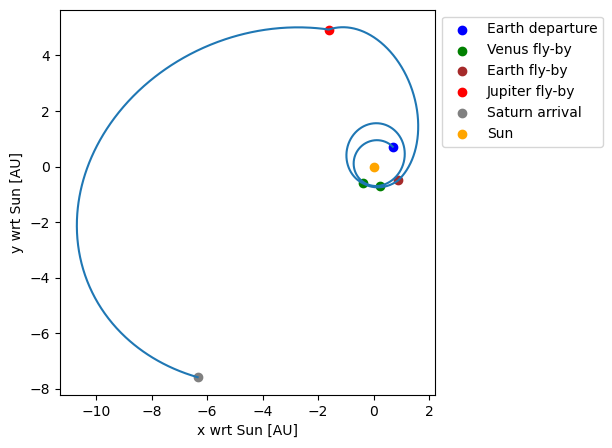

In [9]:
# Reevaluate the transfer trajectory using the champion design variables
node_times, leg_free_parameters, node_free_parameters = convert_trajectory_parameters(
    transfer_trajectory_object, pop.champion_x
)
transfer_trajectory_object.evaluate(
    node_times, leg_free_parameters, node_free_parameters
)

# Extract the state history
state_history = transfer_trajectory_object.states_along_trajectory(500)
fly_by_states = np.array([state_history[node_times[i]] for i in range(len(node_times))])
state_history = result2array(state_history)
au = 1.5e11

# Plot the state history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(state_history[:, 1] / au, state_history[:, 2] / au)
ax.scatter(
    fly_by_states[0, 0] / au,
    fly_by_states[0, 1] / au,
    color="blue",
    label="Earth departure",
)
ax.scatter(
    fly_by_states[1, 0] / au,
    fly_by_states[1, 1] / au,
    color="green",
    label="Venus fly-by",
)
ax.scatter(fly_by_states[2, 0] / au, fly_by_states[2, 1] / au, color="green")
ax.scatter(
    fly_by_states[3, 0] / au,
    fly_by_states[3, 1] / au,
    color="brown",
    label="Earth fly-by",
)
ax.scatter(
    fly_by_states[4, 0] / au,
    fly_by_states[4, 1] / au,
    color="red",
    label="Jupiter fly-by",
)
ax.scatter(
    fly_by_states[5, 0] / au,
    fly_by_states[5, 1] / au,
    color="grey",
    label="Saturn arrival",
)
ax.scatter([0], [0], color="orange", label="Sun")
ax.set_xlabel("x wrt Sun [AU]")
ax.set_ylabel("y wrt Sun [AU]")
ax.set_aspect("equal")
ax.legend(bbox_to_anchor=[1, 1])
plt.show()